In [620]:
!pip install matplotlib
!pip install seaborn

In [1185]:
import numpy as np
from matplotlib import pyplot as plt
import math as mt
import seaborn as sb
import pandas as pd
import scipy.stats as sps
import statistics as st
import os

%matplotlib inline

In [1362]:
class prognoz:
    ''' 

        '''
    value = 0 

    def __init__(self, csv_file, array_x = [], array_y=[]):
        self.csv_file = pd.read_csv(csv_file, sep=';')
        self.array_x = self.csv_file['X'].tolist()
        try:
            self.array_y = [float(i.replace(',','.')) for i in self.csv_file['Y'].tolist()]
        except AttributeError:
            self.array_y = self.csv_file['Y'].tolist()
            
            
    def transform(self):
        return([float(i.replace(',','.')) for i in self.array_y])
    
    def sum_x(self):
        return(sum(self.array_x))
        
    def sum_y(self):
        return(sum(self.array_y[i] for i in range(len(self.array_y))))

    def square_x(self):
        return(sum(self.array_x[i]**2 for i in range(len(self.array_x))))
        
    def sum_xy(self):
        return(sum([self.array_x[i] * self.array_y[i] for i in range(len(self.array_x))]))
    
    def var_a(self):
        return((len(self.array_x)*prognoz.sum_xy(self) - prognoz.sum_x(self) * prognoz.sum_y(self))/
        (len(self.array_x)*prognoz.square_x(self) - (prognoz.sum_x(self)**2)))
    
    def var_b(self):
        return((prognoz.sum_y(self)-prognoz.var_a(self)*prognoz.sum_x(self)) / (len(self.array_x)))
    
    def array_f(self):
        return([prognoz.var_a(self)*self.array_x[i] + prognoz.var_b(self) 
                for i in range(len(self.array_x))])
    
    def approx_func(self):
        a = [prognoz.array_f(self)[i] - (prognoz.var_a(self)*self.array_x[i]+ prognoz.var_b(self)) 
                                         for i in range(len(prognoz.array_f(self)))]
        return([a[i]**2 for i in range(len(a))]) 
     
        '''тут начинается расчет квадратичной функции
        она отличается только тем что добавляются 3 и 4 степени массива x.
            '''
        
    def sum_3_degree(self):
        return(sum(self.array_x[i]**3 for i in range(len(self.array_x))))

    def sum_4_degree(self):
        return(sum(self.array_x[i]**4 for i in range(len(self.array_x))))

    def sum_x2_y(self):
        return(sum([(self.array_x[i]**2)*self.array_y[i] for i in range(len(self.array_x))]))


    def main_matrix(self):
        '''
        основная матрица имеет вид (если что)
            ax^4+bx^3+сx^2
            ax^3+bx^2+cx
            ax^2+bx+cn, 
            где n - длина массива
        '''
        return([
                [prognoz.sum_4_degree(self), prognoz.sum_3_degree(self),prognoz.square_x(self)],
                [prognoz.sum_3_degree(self), prognoz.square_x(self), prognoz.sum_x(self)],
                [prognoz.square_x(self), prognoz.sum_x(self), len(self.array_x)]
                ])
    
    def det(self):
        return(np.linalg.det(np.matrix(prognoz.main_matrix(self))))

    def var_abc(self):
        a = np.array(prognoz.main_matrix(self))
        b = np.array([prognoz.sum_x2_y(self), prognoz.sum_xy(self), prognoz.sum_y(self)])
        return(np.linalg.inv(a).dot(b))
        
    def array_square_f(self):
        return([prognoz.var_abc(self)[0]*(self.array_x[i]**2)+
                (prognoz.var_abc(self)[1]*self.array_x[i])+
                prognoz.var_abc(self)[2] for i in range(len(self.array_x))])
    
    def sigma(self):
        return(round(mt.sqrt((sum([(self.array_y[i]-st.mean(self.array_y))**2 
                             for i in range(len(self.array_y))]))/len(self.array_y)),2))
        
    def dispersion(self):
        avg = sum(self.array_y) / len(self.array_y)
        var = sum((x-avg)**2 for x in self.array_y) / len(self.array_y)
        return(var)
        
    def function_str(self):
        '''проблема: при отрицательных значениях + остается'''
        y1 =('Вид линейной аппроксимирующей функции:\n  y = {}x+{}'
            .format(round(prognoz.var_a(self), 2), round(prognoz.var_b(self), 2)))
        y2 =('Вид квадратичной аппроксимирующей функции:\n  y = {}x^2+{}x+{}'
            .format(round(prognoz.var_abc(self)[0], 2), round(prognoz.var_abc(self)[1], 2),round(prognoz.var_abc(self)[2]), 2))
        y3 = [y1,y2]
        return(y3)
    
    
        #по рисунку, он еще недоработан
    def draw_board(self):
        
        x = np.array(self.array_x)
        y = np.array(self.array_y)
        f = np.array(prognoz.array_f(self))

        ci_68 = np.std(f)
        ci_95 = 2 * np.std(f) 
        ci_99 = 3 * np.std(f)
                    
        fig, axes = plt.subplots(figsize=(12,3), dpi=300)
        axes.plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes.plot(x, f, 'r' , label='Тренд',  linewidth=2)
        
        axes.plot(x, f-ci_68,'g--', label="+- sigma", alpha = 0.5)
        axes.plot(x, f+ci_68,'g--', alpha = 0.5)
        
        axes.plot(x, f-ci_95, 'y.-', label="+- 2sigma", alpha = 0.5)
        axes.plot(x, f+ci_95, 'y.-', alpha = 0.5)

        axes.plot(x, f-ci_99, 'c-.', label="+- 3sigma", alpha = 0.5)
        axes.plot(x, f+ci_99, 'c-.', alpha = 0.5)
        
        plt.text(1,1, s =prog.function_str()[0], fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  
        axes.legend(loc=2)
        axes.set_title('Аппроксимация функции')
        axes.set_xlabel("X")
        axes.set_ylabel("Y, F")
        axes.grid(axis="y")

        return('')
    
    def draw_board_f2(self):

        x = np.array(self.array_x)
        y = np.array(self.array_y)
        f = np.array(prognoz.array_square_f(self))

        ci_68 = np.std(f)
        ci_95 = 2 * np.std(f) 
        ci_99 = 3 * np.std(f)
        
        mean = sum(f) / len(f) 
        var = sum((l-mean)**2 for l in f) / len(f)
        st_dev = math.sqrt(var)
        
        
        ci = st.pstdev(f)
        
        print(np.std(f), ci, st_dev)

        fig, axes = plt.subplots(figsize=(12,3), dpi=300)
        axes.plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes.plot(x, f, 'r' , label='Тренд', linewidth=2)
        
        plt.text(1,1,s=prog.function_str()[1], fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  
        plt.fill_between(x, (f-ci_68), (f+ci_68), color='blue', alpha=0.1)
        plt.fill_between(x, (f-ci_95), (f+ci_95), color='yellow', alpha=.1)
        plt.fill_between(x, (f-ci_99), (f+ci_99), color='blue', alpha=0.1)

        axes.legend(loc=2)
        axes.set_title('Аппроксимация квадратичной функции')
        axes.set_xlabel("X")
        axes.set_ylabel("Y, F")
        axes.grid(axis="y")

        return('')

In [1363]:
prog = prognoz('prog.csv')

276
11128903
4324
128177735
-5305.435770750988
547530.5770750989
[542225.1413043479, 536919.7055335969, 531614.269762846, 526308.833992095, 521003.39822134393, 515697.96245059295, 510392.526679842, 505087.09090909094, 499781.65513833996, 494476.219367589, 489170.783596838, 483865.34782608703, 478559.91205533606, 473254.4762845851, 467949.04051383404, 462643.60474308307, 457338.1689723321, 452032.73320158105, 446727.2974308301, 441421.8616600791, 436116.4258893281, 430810.99011857715, 425505.55434782617]

70136.21166819242 70136.21166819242 70136.21166819242

Вид линейной аппроксимирующей функции:
  y = -5305.44x+547530.58
Вид квадратичной аппроксимирующей функции:
  y = 1545.96x^2+-42408.49x+702127
[  1545.9607284 -42408.4932524 702126.6499153]


[661264.1173913054,
 623493.5063241114,
 588814.8167137214,
 557228.0485601354,
 528733.2018633535,
 503330.2766233756,
 481019.2728402019,
 461800.19051383215,
 445673.02964426647,
 432637.79023150494,
 422694.4722755474,
 415843.0757763939,
 412083.60073404445,
 411416.04714849923,
 413840.41501975793,
 419356.70434782066,
 427964.9151326875,
 439665.04737435834,
 454457.1010728334,
 472341.07622811245,
 493316.9728401955,
 517384.7909090826,
 544544.5304347738]

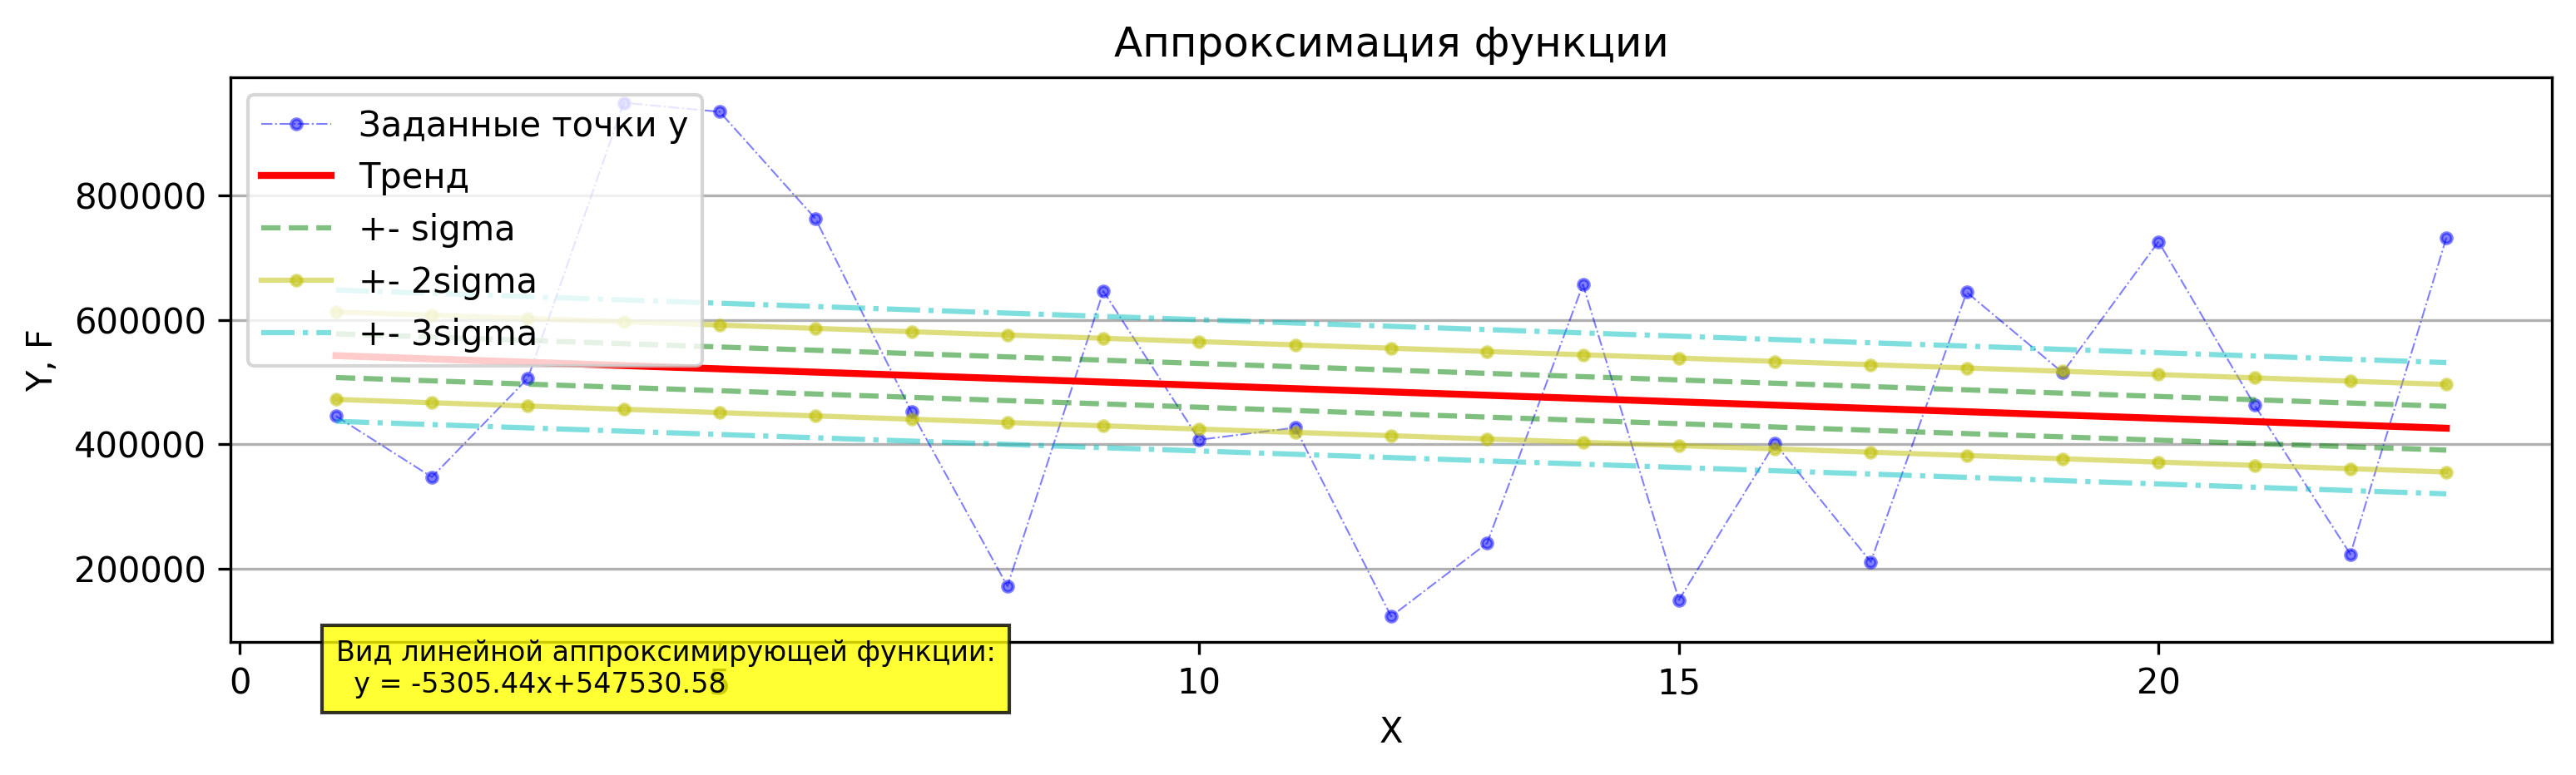

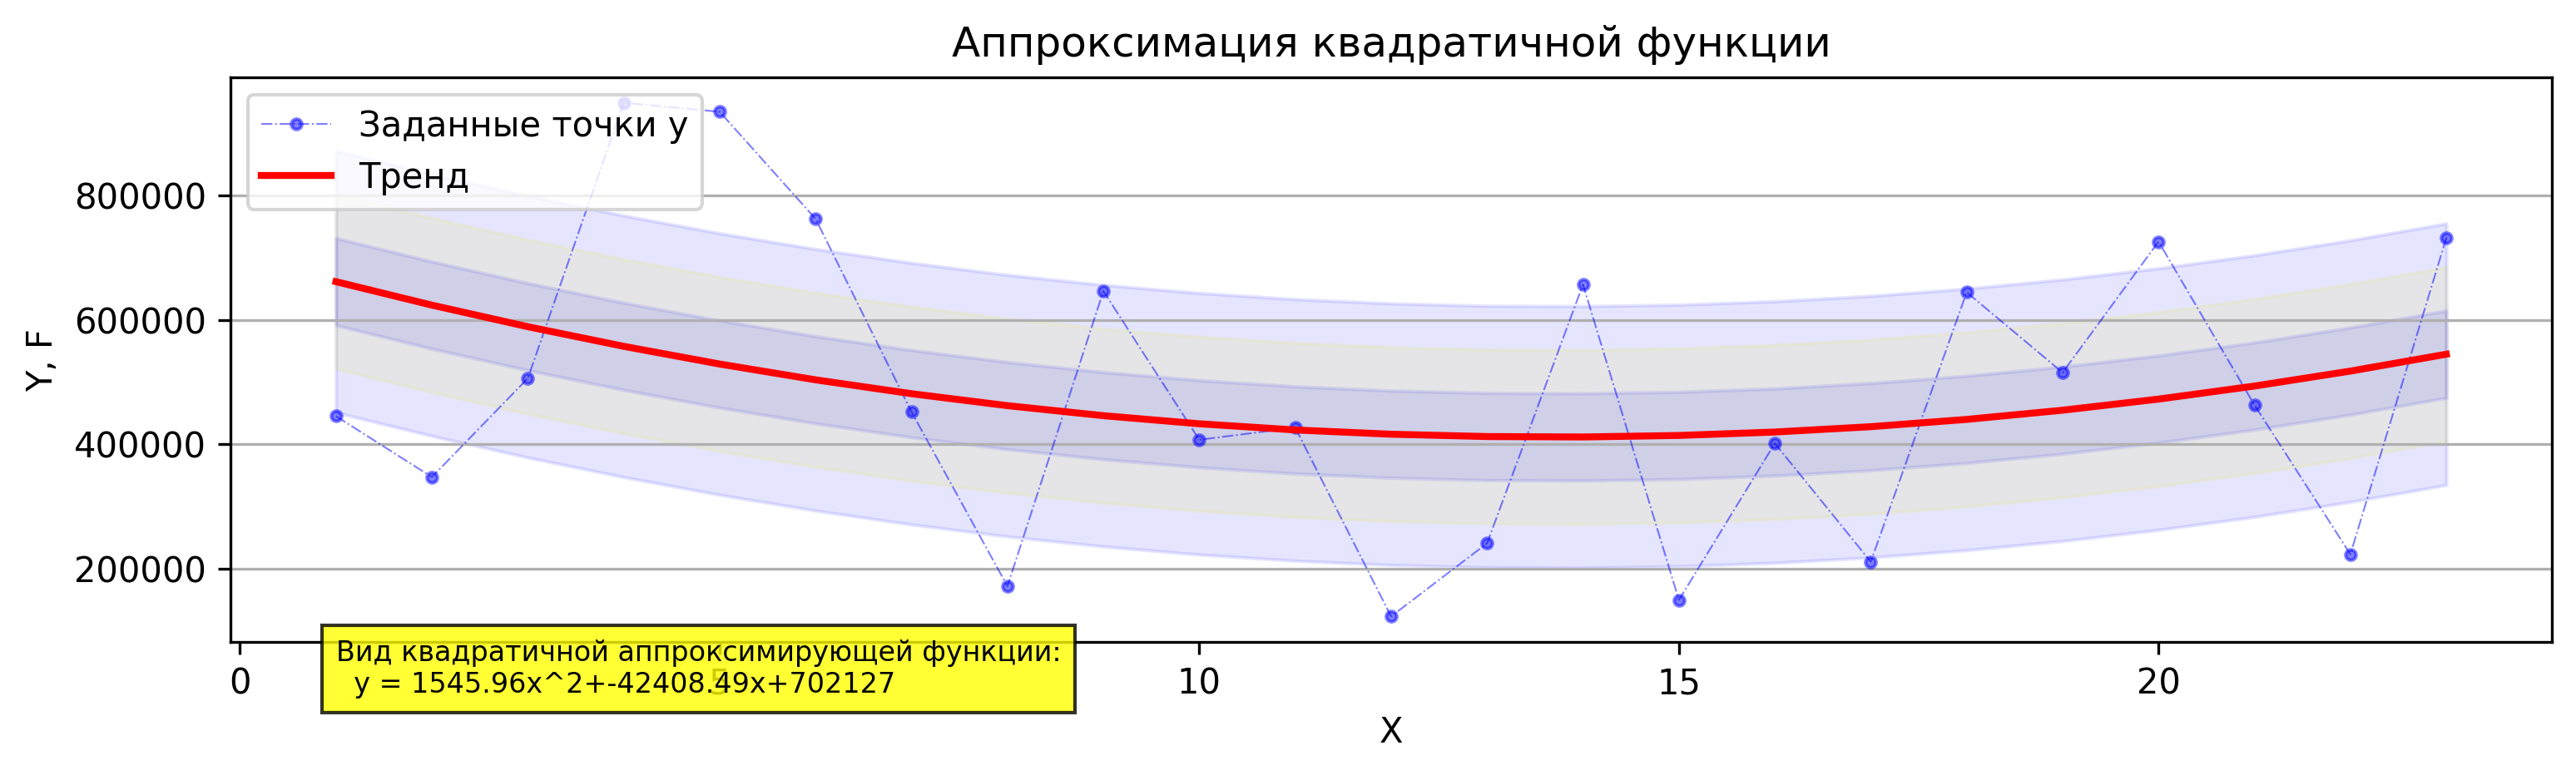

In [1364]:
#не все нижеперечисленное обязано быть вызваным
print(prog.sum_x()) #сумма х
print(prog.sum_y()) #сумма значений y
print(prog.square_x()) #сумма квадратов x
print(prog.sum_xy()) #сумма произведений x и y
print(prog.var_a()) #значение a в линейной
print(prog.var_b()) #значение b в линейной функции
print(prog.array_f()) #аппроксимированные значения
# print(prog.approx_func()) #поиск отклонений, где функция стремится к минимуму для линейной функции 
print(prog.draw_board()) #прорисовка (не закончена)
print(prog.draw_board_f2())
print(prog.function_str()[0])
print(prog.function_str()[1])
print(prog.var_abc())
prog.array_square_f()

In [1286]:
#Задание №1.3 Очистка от выбросов
class clean_csv:
    ''' 

        '''
    def __init__(self, csv, portion = 0.1, max_iter=1000, file_name = 'cleaned_xy.csv'):
        self.csv = csv
        self.portion = portion
        self.max_iter = max_iter
        self.file_name = file_name
        
    def csv_file(self):
        return(pd.read_csv(self.csv, sep =';'))
    
    def boxplot(self):
        csv = clean_csv.csv_file(self)
        boxplot = csv.boxplot(['Y'])
        return(boxplot)
        
    def clean(self):
        csv = clean_csv.csv_file(self)
        for en, x in enumerate(['Y']):
            if en == self.max_iter:
                break
            q_75,q_25 = np.percentile(csv.loc[:,x],[75,25])
            intr_qr = q_75-q_25

            max = q_75+(1.5*intr_qr)
            min = q_25-(1.5*intr_qr)
    
            csv.loc[csv[x] < min,x] = np.nan
            csv.loc[csv[x] > max,x] = np.nan
        csv.isnull().sum()
        csv = csv.dropna(axis = 0)
        return(csv)
    
    def dispersion_difference(self):
        csv = clean_csv.csv_file(self)
        cleaned = clean_csv.clean(self)
        return(csv['Y'].var()-cleaned['Y'].var())
    
    def create_csv(self):
        csv = clean_csv.clean(self)
        try:
            csv.to_csv(self.file_name, sep=';')
        except PermissionError:
            print('Файл в режиме работы. Закройте файл и повторите попытку!')
        return(os.system(self.file_name))
    
    def dir(self):
        return(os.path.abspath(self.file_name))


    X    Y
0   1   25
1   2   89
2   3  235
3   4   15
4   5   56
5   6   48
6   7   65
7   8   75
8   9   93
9  10   42
3107.6499999999996
AxesSubplot(0.125,0.125;0.775x0.755)
Файл в режиме работы. Закройте файл и повторите попытку!
1


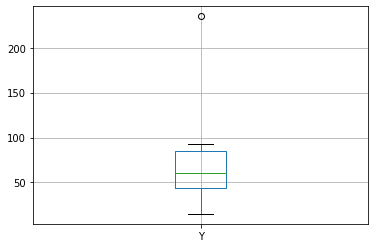

In [1287]:
iqr = clean_csv('prog.csv')#название файла
print(iqr.csv_file()) #датафрейм
#print(iqr.clean()) #очищенная выборка
print(iqr.dispersion_difference()) #пункт 3 в) подсчет разницы дисперсий
print(iqr.boxplot())
print(iqr.create_csv()) #открывает файл

In [637]:
#задание №2